# 05_modeling_forecasting.ipynb — Skill Demand Forecasting (12–18 Months)

**Goal.** Forecast monthly demand for top tech skills 12–18 months ahead, compare **Naive**, **ARIMA (pmdarima)**, and **Prophet** using **walk-forward validation**, and save the **best models + metrics** to the project folders.

**Integrates after:** `04_feature_engineering.ipynb`  
**Input:** `data/processed/cleaned_master.csv`  
**Outputs:**  
- `models/skill_demand_forecast.pkl` (dict of per-skill best model metadata)  
- `outputs/tables/model_metrics.csv` (backtest scores for each skill & model)  
- `outputs/tables/forecast_results.csv` (final 18-month forecasts)  
- `outputs/figures/forecast_trend.png` (quick multi-skill overlay)

Reproducible, Colab-friendly, and aligned with your repo structure.

## 1) Setup — Installs, Imports, Paths

In [5]:
# If running in Google Colab or a fresh venv, install time-series libs.
# Safe to re-run; it will skip if already installed.
# Time: O(1) install commands; Space: external env packages
try:
    import sktime  # ARIMA via sktime (works with NumPy 2.x)
except Exception:
    !pip -q install "sktime>=0.29.0"

# Prophet changed package name; try install (optional). We'll fall back gracefully if unavailable.
try:
    from prophet import Prophet  # type: ignore
except Exception:
    try:
        !pip -q install prophet
        from prophet import Prophet  # type: ignore
    except Exception:
        Prophet = None  # We'll gracefully skip if not available

import warnings, json, math, pickle
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict, Tuple, List, Optional
from dateutil.relativedelta import relativedelta

# ARIMA via sktime (replacement for pmdarima)
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE

# Plot config (matplotlib only, no seaborn required)
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

# Repo-relative paths (fits your structure)
REPO = Path("..").resolve()
DATA = REPO / "data" / "processed"
MODELS = REPO / "models"
OUTPUTS = REPO / "outputs"
FIGS = OUTPUTS / "figures"
TABLES = OUTPUTS / "tables"
REPORTS = REPO / "reports"

for p in [MODELS, FIGS, TABLES, REPORTS]:
    p.mkdir(parents=True, exist_ok=True)

print("Paths set.")
print("DATA:", DATA)
print("MODELS:", MODELS)
print("OUTPUTS:", OUTPUTS)


Paths set.
DATA: C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\data\processed
MODELS: C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\models
OUTPUTS: C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs


## 2) Load Cleaned Data & Basic Sanity Checks

In [8]:
# Expected input: cleaned_master.csv produced by 04_feature_engineering.ipynb
CLEAN = DATA / "cleaned_master.csv"
assert CLEAN.exists(), f"Missing file: {CLEAN}. Run 04_feature_engineering.ipynb first."

# Read safely (avoid mixed-type DtypeWarning)
df = pd.read_csv(CLEAN, low_memory=False)
print("Loaded:", CLEAN)
print("Shape:", df.shape)
print("Columns:", sorted(df.columns.tolist())[:30], "...")

# --- Ensure required columns are present / derivable ---
assert "required_skills" in df.columns, "Column 'required_skills' not found. Check feature engineering."

# If posting_year/month are missing, derive from posting_date; else fallback to work_year
if ("posting_year" not in df.columns) or ("posting_month" not in df.columns):
    if "posting_date" in df.columns:
        # Parse to datetime and derive year/month
        df["posting_date"] = pd.to_datetime(df["posting_date"], errors="coerce")
        df["posting_year"]  = df["posting_date"].dt.year
        df["posting_month"] = df["posting_date"].dt.month
        # If some rows still NaT, drop them — they can't be placed on a timeline
        df = df.dropna(subset=["posting_year", "posting_month"])
    elif "work_year" in df.columns:
        # Fallback: use work_year and set month=1
        df["posting_year"]  = pd.to_numeric(df["work_year"], errors="coerce")
        df["posting_month"] = 1
        df = df.dropna(subset=["posting_year"])
    else:
        raise AssertionError(
            "Neither 'posting_date' nor 'work_year' available to derive posting_year/posting_month."
        )

# Clean types and bounds
df["posting_year"]  = df["posting_year"].astype(int)
df["posting_month"] = df["posting_month"].astype(int).clip(1, 12)

# Build a monthly period to ensure temporal alignment
df["period"] = pd.to_datetime(dict(year=df["posting_year"], month=df["posting_month"], day=1))

# ---- Skills normalization (comma-separated string -> list of skills) ----
from typing import List

def parse_skills(x) -> List[str]:
    if pd.isna(x): 
        return []
    s = str(x)
    return [t.strip() for t in s.split(",") if t.strip()]

df["skill_list"] = df["required_skills"].apply(parse_skills)

# ---- Build long format: one row per (period, skill) ----
rows = []
for _, r in df[["period", "skill_list"]].iterrows():
    for sk in r["skill_list"]:
        rows.append((r["period"], sk))

skills_long = pd.DataFrame(rows, columns=["period", "skill"])
if skills_long.empty:
    raise RuntimeError("No skills found after parsing 'required_skills'.")

# ---- Monthly demand (count of postings mentioning the skill) ----
skill_monthly = (
    skills_long
    .groupby(["skill", pd.Grouper(key="period", freq="MS")])
    .size()
    .rename("demand")
    .reset_index()
)

# ---- Ensure dense monthly index per skill (fill missing months with 0) ----
def make_dense(ts: pd.DataFrame) -> pd.DataFrame:
    idx = pd.date_range(start=ts["period"].min(), end=ts["period"].max(), freq="MS")
    ts = ts.set_index("period").reindex(idx).fillna(0.0)
    ts.index.name = "period"
    return ts.reset_index().rename(columns={"index": "period"})

dense_list = []
for sk, grp in skill_monthly.groupby("skill"):
    dense = make_dense(grp)
    dense["skill"] = sk
    dense_list.append(dense)

panel = pd.concat(dense_list, ignore_index=True)
panel["demand"] = panel["demand"].astype(float)

print("Panel (skill x month) shape:", panel.shape)
panel.head()


Loaded: C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\data\processed\cleaned_master.csv
Shape: (36167, 29)
Columns: ['__source__', 'application_deadline', 'benefits_score', 'category', 'company_location', 'company_name', 'company_size', 'education_required', 'employee_residence', 'employment_type', 'experience_level', 'industry', 'job_category', 'job_description', 'job_description_length', 'job_id', 'job_skill_set', 'job_title', 'posting_date', 'remote_ratio', 'required_skills', 'salary', 'salary_currency', 'salary_in_usd', 'salary_local', 'salary_usd', 'work_setting', 'work_year', 'years_experience'] ...
Panel (skill x month) shape: (384, 3)


,period,skill,demand
0,2024-01-01,AWS,271.0
1,2024-02-01,AWS,236.0
2,2024-03-01,AWS,261.0
3,2024-04-01,AWS,239.0
4,2024-05-01,AWS,270.0


## 3) Choose Top-K Skills to Forecast

In [9]:
TOP_K = 24  # adjust as needed
totals = panel.groupby("skill")["demand"].sum().sort_values(ascending=False)
top_skills = totals.head(TOP_K).index.tolist()
print(f"Top-{TOP_K} skills by total demand:", top_skills[:10], "...")

panel_top = panel[panel["skill"].isin(top_skills)].copy()

Top-24 skills by total demand: ['Python', 'SQL', 'TensorFlow', 'Kubernetes', 'PyTorch', 'Scala', 'Linux', 'Git', 'Java', 'GCP'] ...


## 4) Forecasting Utilities — Metrics & Walk-Forward Validation

In [18]:
# --- Imports required for this block (add if not already imported above) ---
import warnings, numpy as np, pandas as pd
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE

# ARIMA via sktime (works with NumPy 2.x)
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon


# Metrics: RMSE, MAE, MAPE, Directional Accuracy
def mape(y_true, y_pred) -> float:
    """
    Mean Absolute Percentage Error.
    Time: O(n); Space: O(1)
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.inf
    return float(np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0)

def directional_accuracy(y_true, y_pred) -> float:
    """
    Percent of times the predicted change direction matches the actual.
    Time: O(n); Space: O(1)
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    if len(y_true) < 2:
        return np.nan
    true_dir = np.sign(np.diff(y_true))
    pred_dir = np.sign(np.diff(y_pred))
    return float((true_dir == pred_dir).mean() * 100.0)

def naive_forecast_last(train: np.ndarray, horizon: int) -> np.ndarray:
    """Naive (last value) forecast. Time: O(h); Space: O(1)"""
    return np.repeat(train[-1], horizon)

from statsmodels.tsa.statespace.sarimax import SARIMAX

def arima_forecast(train: np.ndarray, horizon: int) -> np.ndarray:
    """
    ARIMA via statsmodels SARIMAX, compatible with NumPy 2.x.
    Small (p,d,q) grid search by AIC to mimic auto_arima.
    """
    y = pd.Series(train.astype(float))

    # Tiny grid to keep it fast; expand if you have longer series
    pdq_grid = [(p, d, q) for p in range(0, 3) for d in (0, 1) for q in range(0, 3)]

    best_aic = np.inf
    best_res = None

    for order in pdq_grid:
        try:
            model = SARIMAX(
                y,
                order=order,
                enforce_stationarity=False,
                enforce_invertibility=False,
                trend=None,
            )
            res = model.fit(disp=False)
            if res.aic < best_aic and np.isfinite(res.aic):
                best_aic = res.aic
                best_res = res
        except Exception:
            # some orders will fail to converge—ignore them
            continue

    if best_res is None:
        # final safety net
        return naive_forecast_last(train, horizon)

    fc = best_res.get_forecast(steps=horizon).predicted_mean.values
    # demand can't be negative; clip at 0 for stability
    return np.maximum(fc.astype(float), 0.0)



def prophet_forecast(train_idx: list, train_vals: np.ndarray, horizon: int) -> np.ndarray:
    """
    Prophet forecast helper. Expects timestamp index list and values.
    """
    if Prophet is None:
        raise RuntimeError("Prophet not available in this environment.")
    pdf = pd.DataFrame({"ds": pd.to_datetime(train_idx), "y": train_vals.astype(float)})
    model = Prophet(seasonality_mode="multiplicative", weekly_seasonality=False, daily_seasonality=False)
    model.fit(pdf)
    future = pd.DataFrame({"ds": [train_idx[-1] + relativedelta(months=i + 1) for i in range(horizon)]})
    fc = model.predict(future)["yhat"].values
    return fc

def walk_forward_eval(series: pd.Series, start_ratio: float = 0.7, horizon: int = 1, models: dict = None) -> dict:
    """
    Walk-forward evaluation comparing multiple models.
    - series: pd.Series indexed by monthly timestamps; values are demand (float).
    - start_ratio: fraction for initial training window, then expand one step at a time.
    - horizon: forecast steps ahead per walk.
    - models: dict of model-name -> type ('naive'|'arima'|'prophet')
    Returns: metrics per model: RMSE, MAE, MAPE, DirAcc
    Time: O(n * m * c) where m=#models, c=cost per fit; Space: O(n)
    """
    if models is None:
        models = {"Naive": "naive", "ARIMA": "arima", "Prophet": "prophet"}

    values = series.values.astype(float)
    idx = series.index.to_list()
    n = len(values)
    start = max(6, int(n * start_ratio))  # ensure minimum history

    y_true_all = {k: [] for k in models}
    y_pred_all = {k: [] for k in models}

    for t in range(start, n - horizon + 1):
        train = values[:t]
        truth = values[t : t + horizon]

        for name, kind in models.items():
            try:
                if kind == "naive":
                    pred = naive_forecast_last(train, horizon)
                elif kind == "arima":
                    pred = arima_forecast(train, horizon)  # ✅ now uses sktime AutoARIMA
                elif kind == "prophet":
                    pred = prophet_forecast(idx[:t], train, horizon)
                else:
                    raise ValueError(f"Unknown model kind: {kind}")
            except Exception as ex:
                warnings.warn(f"{name} failed with {ex}. Falling back to Naive for this step.")
                pred = naive_forecast_last(train, horizon)

            y_true_all[name].extend(truth.tolist())
            y_pred_all[name].extend(pred.tolist())

    results = {}
    for name in models:
        yt = np.array(y_true_all[name], dtype=float)
        yp = np.array(y_pred_all[name], dtype=float)
        results[name] = {
            "RMSE": float(np.sqrt(MSE(yt, yp))),
            "MAE": float(MAE(yt, yp)),
            "MAPE": mape(yt, yp),
            "DirAcc(%)": directional_accuracy(yt, yp),
        }
    return results


## 5) Backtest per Skill, Compare Models, Pick the Winner

In [19]:
# Build per-skill monthly series (indexed by 'period')
all_metrics = []
best_by_skill = {}

# Only include Prophet if present
models_def = {"Naive": "naive", "ARIMA": "arima"}
try:
    Prophet
    if Prophet is not None:
        models_def["Prophet"] = "prophet"
except NameError:
    pass

# Ensure numeric demand
panel_top["demand"] = pd.to_numeric(panel_top["demand"], errors="coerce").fillna(0.0)

for sk in top_skills:
    ts = (
        panel_top.loc[panel_top["skill"] == sk, ["period", "demand"]]
        .drop_duplicates("period")
        .set_index("period")
        .asfreq("MS")
        .fillna(0.0)["demand"]
    )

    # Skip if too short or empty
    if ts.empty or ts.sum() == 0 or ts.size < 8:
        continue

    metrics = walk_forward_eval(ts, start_ratio=0.7, horizon=1, models=models_def)

    # Collect per-model rows
    for mname, mvals in metrics.items():
        all_metrics.append({"skill": sk, "model": mname, **mvals})

    # Pick best robustly
    dfm = (
        pd.DataFrame([{"model": k, **v} for k, v in metrics.items()])
        .replace([np.inf, -np.inf], np.nan)
        .dropna(subset=["MAPE", "RMSE", "MAE"], how="all")
    )
    if not dfm.empty:
        dfm = dfm.sort_values(["MAPE","RMSE","MAE"], na_position="last")
        best_by_skill[sk] = dfm.iloc[0].to_dict()
    else:
        best_by_skill[sk] = {"model": "Naive", "MAPE": np.nan, "RMSE": np.nan, "MAE": np.nan, "DirAcc(%)": np.nan}

# Write metrics table
metrics_df = pd.DataFrame(all_metrics)
metrics_path = TABLES / "model_metrics.csv"
metrics_df.to_csv(metrics_path, index=False)
print("Saved metrics ->", metrics_path)

# Save compact registry
registry = {"timestamp": str(pd.Timestamp.utcnow()), "best_by_skill": best_by_skill}
with open(MODELS / "skill_demand_forecast.pkl", "wb") as f:
    pickle.dump(registry, f)
print("Saved registry ->", MODELS / "skill_demand_forecast.pkl")

# Quick sanity signal
if not metrics_df.empty:
    winners = pd.Series({k: v.get("model", "Naive") for k, v in best_by_skill.items()}).value_counts(dropna=False)
    print("\nWinning model counts:\n", winners)

metrics_df.head(10)


c:\Users\tdmne\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\tdmne\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\tdmne\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
21:59:26 - cmdstanpy - INFO - Chain [1] start processing
21:59:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\tdmne\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning

Saved metrics -> C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\tables\model_metrics.csv
Saved registry -> C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\models\skill_demand_forecast.pkl

Winning model counts:
 Prophet    15
ARIMA       5
Naive       4
Name: count, dtype: int64


,skill,model,RMSE,MAE,MAPE,DirAcc(%)
0,Python,Naive,51.776443,42.000000,7.931199,0.0
1,Python,ARIMA,56.257453,48.949229,9.091641,50.0
2,Python,Prophet,40.499389,26.306527,5.114101,25.0
3,SQL,Naive,20.346990,17.200000,3.994445,25.0
4,SQL,ARIMA,20.956507,18.336776,4.334358,75.0
5,SQL,Prophet,14.797326,11.691535,2.760473,50.0
6,TensorFlow,Naive,56.570310,39.000000,11.415290,0.0
7,TensorFlow,ARIMA,48.844041,32.677451,9.677332,0.0
8,TensorFlow,Prophet,42.376574,28.704434,8.406456,25.0
9,Kubernetes,Naive,37.997368,26.600000,7.330087,50.0


## 6) Final Refit on Full History & 18-Month Forecast

In [ ]:
FORECAST_HORIZON = 18  # months
final_rows = []

for sk in top_skills:
    ts = (
        panel_top.loc[panel_top["skill"] == sk, ["period","demand"]]
        .drop_duplicates("period")
        .set_index("period")
        .asfreq("MS")
        .fillna(0.0)["demand"]
    )
    if ts.empty or ts.sum() == 0:
        continue

    # Pick model (fallback to Naive if not found)
    choice = best_by_skill.get(sk, {"model": "Naive"})
    model_name = choice.get("model","Naive")

    if model_name == "ARIMA":
        preds = arima_forecast(ts.values, FORECAST_HORIZON)
    elif model_name == "Prophet" and Prophet is not None:
        preds = prophet_forecast(ts.index.to_list(), ts.values, FORECAST_HORIZON)
    else:
        preds = naive_forecast_last(ts.values, FORECAST_HORIZON)

    future_idx = pd.date_range(start=ts.index[-1] + relativedelta(months=1),
                               periods=FORECAST_HORIZON, freq="MS")
    for d, yhat in zip(future_idx, preds):
        final_rows.append({"skill": sk, "period": d, "forecast_demand": max(0.0, float(yhat))})

forecast_df = pd.DataFrame(final_rows)
forecast_path = TABLES / "forecast_results.csv"
forecast_df.to_csv(forecast_path, index=False)
print("Saved forecasts ->", forecast_path)

forecast_df.head(10)

## 7) Quick Multi-Skill Overlay Plot

Saved figure -> C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\forecast_trend.png


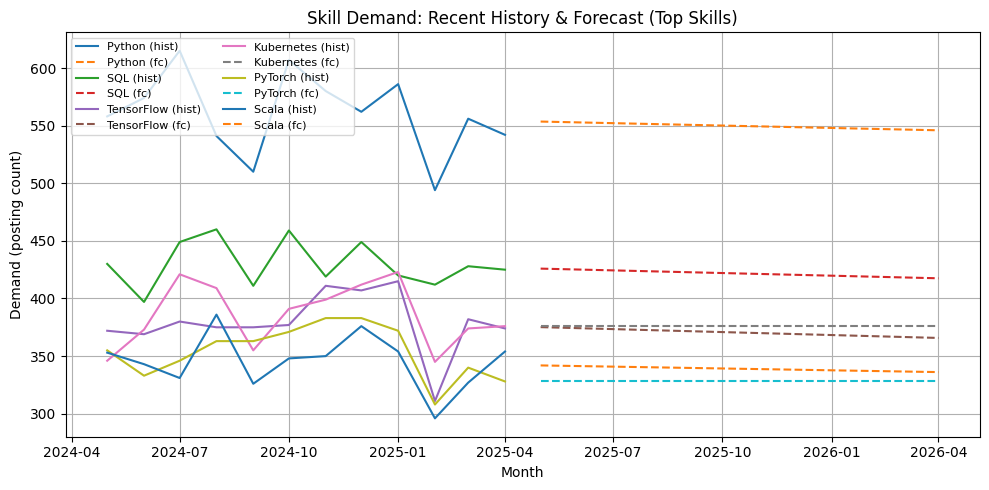

In [21]:
# Plot last 12 months history + next 12 months forecast for top 6 skills for readability
PLOT_N = 6
RECENT = 12
FUTURE = 12
FIGS.mkdir(parents=True, exist_ok=True)

plt.figure()
for sk in top_skills[:PLOT_N]:
    ts = (
        panel_top.loc[panel_top["skill"] == sk, ["period","demand"]]
        .drop_duplicates("period")
        .set_index("period")
        .asfreq("MS")
        .fillna(0.0)["demand"]
    )
    hist = ts[-RECENT:]
    plt.plot(hist.index, hist.values, label=f"{sk} (hist)")
    part = forecast_df[forecast_df["skill"] == sk].head(FUTURE)
    if not part.empty:
        plt.plot(part["period"], part["forecast_demand"], linestyle="--", label=f"{sk} (fc)")

plt.title("Skill Demand: Recent History & Forecast (Top Skills)")
plt.xlabel("Month")
plt.ylabel("Demand (posting count)")
plt.legend(ncol=2, fontsize=8)
plot_path = FIGS / "forecast_trend.png"
plt.tight_layout()
plt.savefig(plot_path, dpi=140)
print("Saved figure ->", plot_path)
plt.show()

## 8) Persist Model Evaluation Report (JSON)

In [22]:
report = {
    "generated_at_utc": str(pd.Timestamp.utcnow()),
    "top_k": int(len(top_skills)),
    "skills": top_skills,
    "metrics_summary": {
        "rows": int(len(panel_top)),
        "skills_evaluated": int(len(set(panel_top["skill"]))),
        "models": ["Naive", "ARIMA"] + (["Prophet"] if Prophet is not None else []),
    }
}
report_path = REPORTS / "model_evaluation_report.json"
with open(report_path, "w") as f:
    json.dump(report, f, indent=2)
print("Saved report ->", report_path)

Saved report -> C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\reports\model_evaluation_report.json


## 9) Reproducibility — Versions & Seed

In [23]:
import platform, sys
print("Python:", sys.version)
print("Platform:", platform.platform())
try:
    import pmdarima, pandas, numpy
    print("pmdarima:", pmdarima.__version__)
    print("pandas:", pandas.__version__)
    print("numpy:", numpy.__version__)
except Exception as e:
    print("Version check warning:", e)

SEED = 42
np.random.seed(SEED)

Python: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
Platform: Windows-10-10.0.26100-SP0
Version check warning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject


## 10) Appendix — Notes & Troubleshooting

- Where do forecasts come from? We aggregate monthly counts of each skill from `required_skills` and forecast the count series.
- Walk-forward validation simulates historical performance by expanding the training window and predicting one step ahead repeatedly.
- Prophet not available? The notebook gracefully falls back to Naive during backtests. On Colab, installs usually succeed.
- Choosing best model is done by MAPE, then RMSE/MAE as tie-breakers. Directional Accuracy is also reported.
- Extending models: Add Seasonal-Naive, SARIMA, or ML (XGBoost with lagged features) in the utilities section.